# LIME visualization
## Imports

In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

import jax
from flax.linen import relu
from flax.linen.initializers import kaiming_uniform

from skimage.segmentation import mark_boundaries, slic

from sklearn.linear_model import Ridge

from lime.lime_tabular import LimeTabularExplainer
from lime.lime_image import LimeImageExplainer

from data_loaders import load_cifar10, load_wine_quality
from models import Cifar10CNN, WineQualityNetwork, create_model, load_weights
from utils import prediction

C:\Users\marlo\anaconda3\envs\blackbox_lime\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model setup
Please write the directory to the dataset in here if it is not the default one:

In [2]:
datapath = './data'

In [3]:
#random number generator key (seed)
rng = jax.random.PRNGKey(0)

#download datasets and store the splits
cif_train, cif_val, cif_test = load_cifar10(datapath)
wine_train, wine_val, wine_test = load_wine_quality(datapath)

#load models
cifar_model, _ = create_model(Cifar10CNN, rng, init_func=kaiming_uniform(), activation_func=relu)
wine_model, _ = create_model(WineQualityNetwork, rng, input_shape=(1, 11), init_func=kaiming_uniform(), activation_func=relu)

#create weight dictionary
weights = {
    'cifar' : {
        0 : load_weights(f'./model_checkpoints/cifar10/kaiming_uniform/relu/initial_weights.pkl'),
        1 : load_weights(f'./model_checkpoints/cifar10/kaiming_uniform/relu/best_weights.pkl'),
        2 : load_weights(f'./model_checkpoints/cifar10/kaiming_uniform/relu/overtrained_model.pkl')
                },
    'wine' : {
        0 : load_weights(f'./model_checkpoints/wine_quality/kaiming_uniform/relu/initial_weights.pkl'),
        1 : load_weights(f'./model_checkpoints/wine_quality/kaiming_uniform/relu/best_weights.pkl'),
        2 : load_weights(f'./model_checkpoints/wine_quality/kaiming_uniform/relu/overtrained_model.pkl')
                }
}

## Wine Tabular Explanation

In [4]:
unbatched_wine = wine_test.unbatch()
    
wine_data = np.array([sample[0].numpy() for sample in unbatched_wine])
wine_labels = np.array([sample[1].numpy() for sample in unbatched_wine])

wine_explainer = LimeTabularExplainer(
    wine_data, 
    mode='classification', 
    training_labels=wine_labels,
    feature_names=[
        'fixed acidity', 'volatile acidity', 'citric acid',
        'residual sugar', 'chlorides', 'free sulfur dioxide',
        'total sulfur dioxide', 'density', 'pH', 'sulphates',
        'alcohol'],
    class_names=[f'Quality {i+1}' for i in range(10)]
)

In [5]:
#we define a lambda function to explain any sample from the data
wine_explanation_func = lambda sample : wine_explainer.explain_instance(data_row=sample, predict_fn=lambda data: prediction(weights['wine'][1], wine_model, data))

C:\Users\marlo\anaconda3\envs\blackbox_lime\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


[<Figure size 640x480 with 1 Axes>]

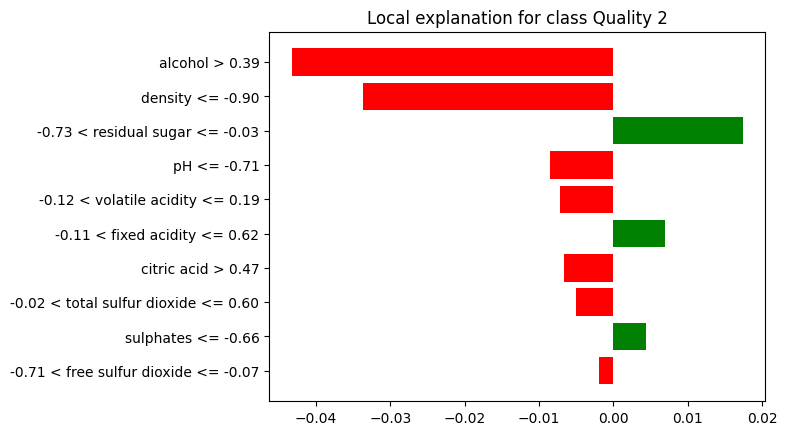

In [6]:
#explain multiple examples
# wine_explanations = [wine_explanation_func(wine_data[i]) for i in range(10)]
#explain one example
wine_explanations = [wine_explanation_func(wine_data[42])]

#we visualize all examples
[exp.as_pyplot_figure() for i, exp in enumerate(wine_explanations)]

## Cifar Image Explanation

In [7]:
unbatched_cifar = cif_test.unbatch()
    
cifar_data = np.array([sample[0].numpy() for sample in unbatched_cifar])
cifar_labels = np.array([sample[1].numpy() for sample in unbatched_cifar])

#pick a feature selection function ('forward_selection', 'lasso_path', 'none', 'auto')
feature_selection = 'auto'
num_features = 15

#pick a segmentation algorithm with parameters as lambda function taking in sample
segmentation_fn = lambda sample: slic(sample, n_segments=15)

cifar_explainer = LimeImageExplainer(feature_selection=feature_selection, random_state=42)

In [8]:
#we define a lambda function to explain any sample from the data
cifar_explanation_func = lambda sample : cifar_explainer.explain_instance(
    sample, 
    classifier_fn=lambda data: prediction(weights['cifar'][1], cifar_model, data), 
    num_features=num_features, 
    random_seed=42, 
    segmentation_fn=segmentation_fn
)

In [9]:
cifar_explanations = [cifar_explanation_func(cifar_data[i]) for i in range(10)]

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 636.05it/s]


In [10]:
def visualize_lime_img(img, neg_mask, pos_mask, top_label):
    fig, axes = plt.subplots(1, 3, figsize=(8, 4))

    axes[0].imshow(neg_mask)
    axes[0].set_title(f"Negative Mask for top label: {['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][top_label]}")
    axes[0].axis("off")

    axes[1].imshow(img)
    axes[1].set_title("Original")
    axes[1].axis("off")

    axes[2].imshow(pos_mask)
    axes[2].set_title(f"Positive Mask for top label: {['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][top_label]}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

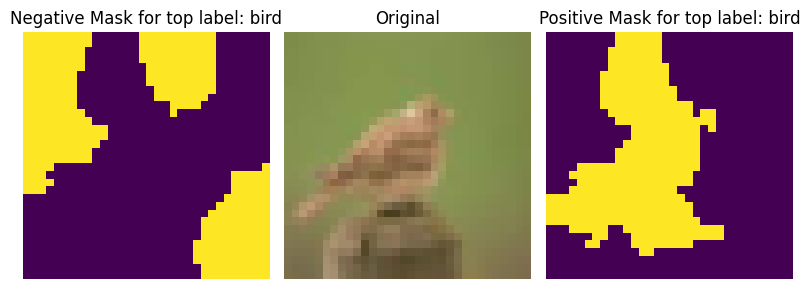

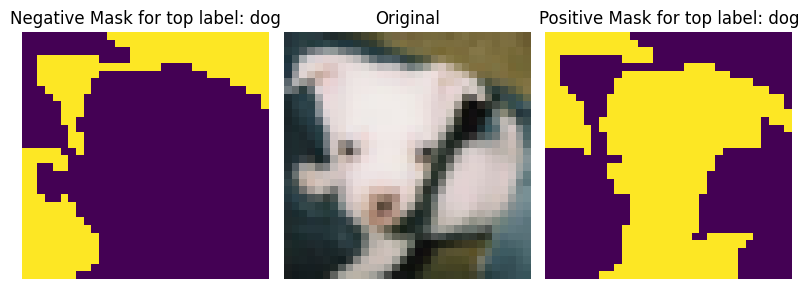

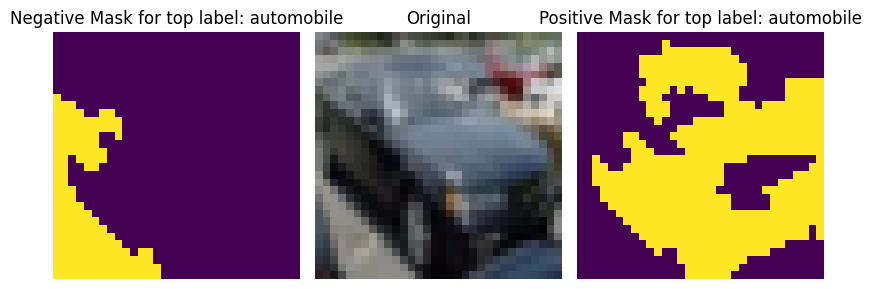

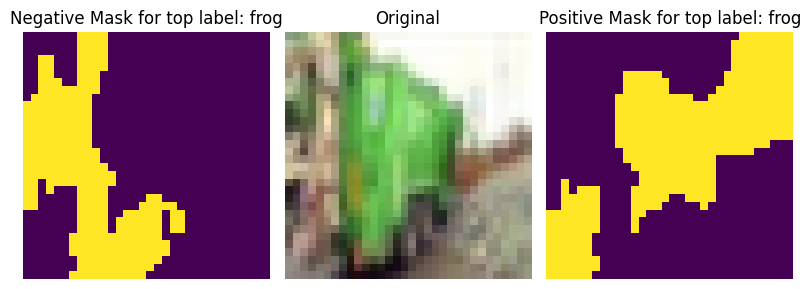

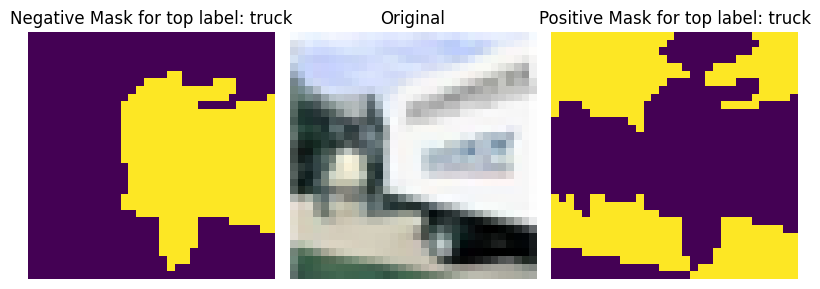

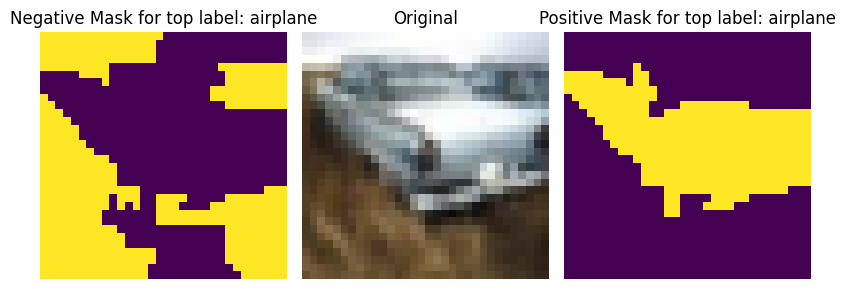

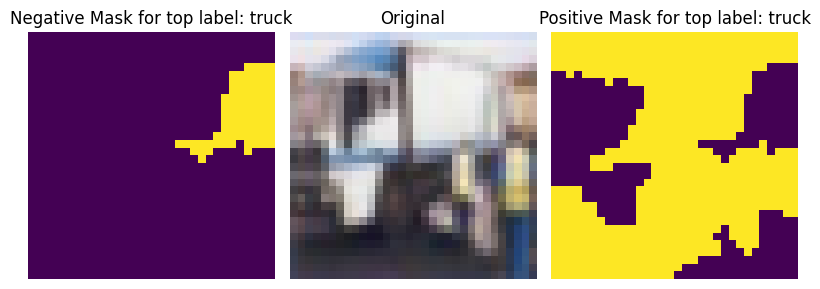

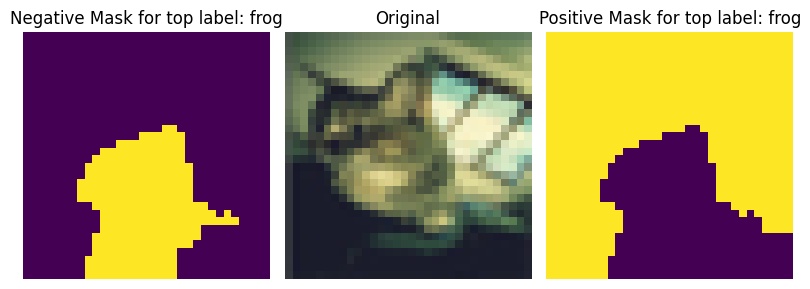

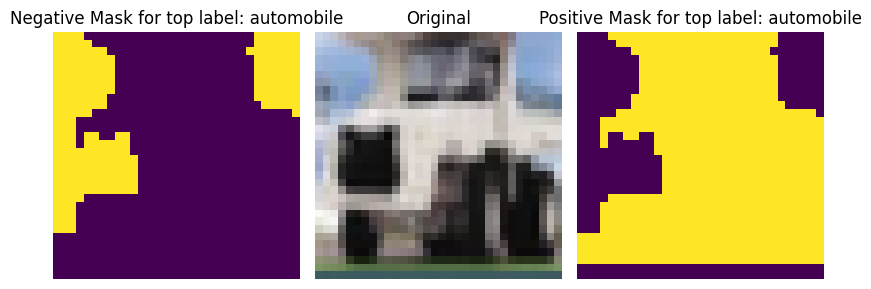

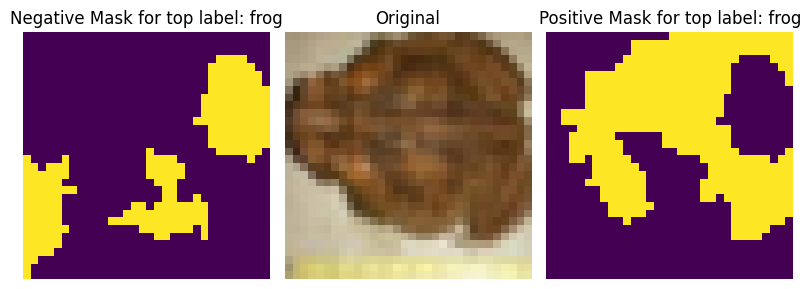

In [12]:
for i, epx in enumerate(cifar_explanations):
    top_label = cifar_explanations[i].top_labels[0]

    original_img = cifar_data[i]
    _, pos_mask = cifar_explanations[i].get_image_and_mask(top_label, positive_only=True, hide_rest=True)
    _, neg_mask = cifar_explanations[i].get_image_and_mask(top_label, positive_only=False, negative_only=True, hide_rest=True)
    
    visualize_lime_img(original_img, neg_mask, pos_mask, top_label=top_label)